In [82]:
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
tfd = tfp.distributions

# https://blog.tensorflow.org/2019/03/regression-with-probabilistic-layers-in.html

In [83]:
# Neg-Loglikelihood function.
negloglik = lambda y, p_y: -p_y.log_prob(y)

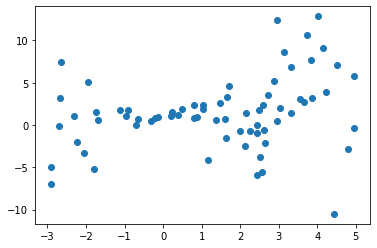

In [150]:
# Generate data samples with heteroscedastic noise.
n_points=70
xmin = -3.0
xmax = 5.0
x=tf.random.uniform([n_points],minval=xmin,maxval=xmax)
dist = tfd.Normal(loc=0.0,scale=1.0)
eps1 = dist.sample([n_points])
eps2 = dist.sample([n_points])

def func(x, eps1, eps2):
    return 0.5*x+0.1*eps1+1.6*x*eps2+1
y=func(x, eps1, eps2)
plt.scatter(x, y)

## Simple linear regression, no uncertainty.

In [151]:
# Simple linear regression model.
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))
])

# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False)
[print(np.squeeze(w.numpy())) for w in model.weights]

0.3917166
0.8256035


[None, None]

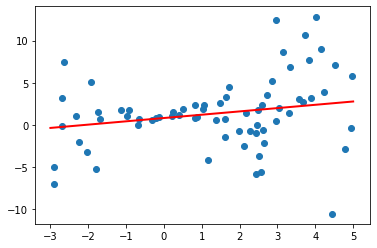

In [152]:
# Evaluate test points.
xtst = tf.expand_dims(tf.linspace(xmin, xmax, 100), 1)
ydist = model(xtst)

plt.plot(xtst, ydist.mean(), 'r', linewidth=2)
plt.scatter(x, y)
plt.show()

## Aleatoric uncertainty

In [153]:
# Linear regression model, computing mean and variance of the predictive distribution.
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(1 + 1),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t[..., :1], 
                                                       scale=1e-3 + tf.math.softplus(0.05*t[..., 1:])))
])

# Do inference.
model2.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model2.fit(x, y, epochs=500, verbose=False)

In [ ]:
# evaluate test points
xtst = tf.expand_dims(tf.linspace(xmin, xmax, 100), 1)
ydist = model2(xtst)

plt.plot(xtst, ydist.mean(), 'r', linewidth=2)
plt.plot(xtst, ydist.mean() + 2*ydist.stddev(), 'g', linewidth=2)
plt.plot(xtst, ydist.mean() - 2*ydist.stddev(), 'g', linewidth=2)
plt.scatter(x, y)
plt.show()

## Bayesian regression

In [ ]:
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
      n = kernel_size + bias_size
      c = np.log(np.expm1(1.))
      return tf.keras.Sequential([
          tfp.layers.VariableLayer(2 * n, dtype=dtype),
          tfp.layers.DistributionLambda(lambda t: tfd.Independent(
              tfd.Normal(loc=t[..., :n],
                         scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
              reinterpreted_batch_ndims=1)),
      ])

In [ ]:
def prior_trainable(kernel_size, bias_size=0, dtype=None):
      n = kernel_size + bias_size
      return tf.keras.Sequential([
          tfp.layers.VariableLayer(n, dtype=dtype),
          tfp.layers.DistributionLambda(lambda t: tfd.Independent(
              tfd.Normal(loc=t, scale=1),
              reinterpreted_batch_ndims=1)),
      ])

In [ ]:
# Linear regression model with DenseVariational Layer, capturing epistemic uncertainty.
model = tf.keras.Sequential([
    tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))
])
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model.fit(x, y, epochs=500, verbose=False)
[print(np.squeeze(w.numpy())) for w in model.weights]

In [ ]:
# evaluate test points
xtst = tf.expand_dims(tf.linspace(-2*abs(xmin), 2*xmax, 100), 1)
ydists = [model(xtst) for i in range(20)]

for ydist in ydists:
    plt.plot(xtst, ydist.mean(), 'r', linewidth=1)
plt.scatter(x, y)
plt.show()

## Bayesian Regression & aleatoric uncertainty

In [ ]:
# Linear regression model with DenseVariational Layer, capturing epistemic uncertainty and
# dual output to predict gaussian predictive distribution.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

In [ ]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False)
[print(np.squeeze(w.numpy())) for w in model.weights]

In [ ]:
# evaluate test points
xtst = tf.expand_dims(tf.linspace(xmin, xmax, 100), 1)
ydists = [model(xtst) for i in range(20)]

for ydist in ydists:
    plt.plot(xtst, ydist.mean(), 'r', linewidth=1)
    plt.plot(xtst, ydist.mean() + 2*ydist.stddev(), 'g', linewidth=1)
    plt.plot(xtst, ydist.mean() - 2*ydist.stddev(), 'g', linewidth=1)
plt.scatter(x, y)
plt.show()

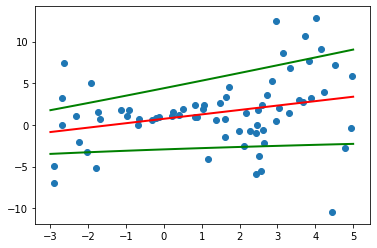

## Bayesian regression

In [155]:
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
      n = kernel_size + bias_size
      c = np.log(np.expm1(1.))
      return tf.keras.Sequential([
          tfp.layers.VariableLayer(2 * n, dtype=dtype),
          tfp.layers.DistributionLambda(lambda t: tfd.Independent(
              tfd.Normal(loc=t[..., :n],
                         scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
              reinterpreted_batch_ndims=1)),
      ])

In [156]:
def prior_trainable(kernel_size, bias_size=0, dtype=None):
      n = kernel_size + bias_size
      return tf.keras.Sequential([
          tfp.layers.VariableLayer(n, dtype=dtype),
          tfp.layers.DistributionLambda(lambda t: tfd.Independent(
              tfd.Normal(loc=t, scale=1),
              reinterpreted_batch_ndims=1)),
      ])

In [157]:
# Linear regression model with DenseVariational Layer, capturing epistemic uncertainty.
model = tf.keras.Sequential([
    tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
    tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc=t, scale=1))
])
# Do inference.
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss=negloglik)
model.fit(x, y, epochs=500, verbose=False)
[print(np.squeeze(w.numpy())) for w in model.weights]

[ 0.61601394  0.83708936 -3.3129618  -2.5582066 ]
[0.63638663 0.927931  ]


[None, None]

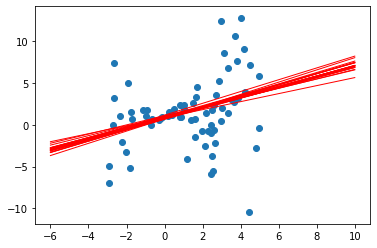

In [158]:
# evaluate test points
xtst = tf.expand_dims(tf.linspace(-2*abs(xmin), 2*xmax, 100), 1)
ydists = [model(xtst) for i in range(20)]

for ydist in ydists:
    plt.plot(xtst, ydist.mean(), 'r', linewidth=1)
plt.scatter(x, y)
plt.show()

## Bayesian Regression & aleatoric uncertainty

In [159]:
# Linear regression model with DenseVariational Layer, capturing epistemic uncertainty and
# dual output to predict gaussian predictive distribution.
model = tf.keras.Sequential([
  tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight=1/x.shape[0]),
  tfp.layers.DistributionLambda(
      lambda t: tfd.Normal(loc=t[..., :1],
                           scale=1e-3 + tf.math.softplus(0.01 * t[...,1:]))),
])

In [160]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=negloglik)
model.fit(x, y, epochs=1000, verbose=False)
[print(np.squeeze(w.numpy())) for w in model.weights]

[ 0.4644162  13.626177    0.80079174 21.896631   -3.0302262  -0.7333347
 -2.6792781  -0.31840858]
[ 0.4607707  13.386719    0.79315585 20.95131   ]


[None, None]

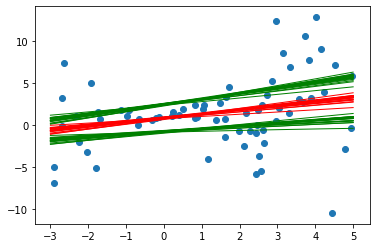

In [161]:
# evaluate test points
xtst = tf.expand_dims(tf.linspace(xmin, xmax, 100), 1)
ydists = [model(xtst) for i in range(20)]

for ydist in ydists:
    plt.plot(xtst, ydist.mean(), 'r', linewidth=1)
    plt.plot(xtst, ydist.mean() + 2*ydist.stddev(), 'g', linewidth=1)
    plt.plot(xtst, ydist.mean() - 2*ydist.stddev(), 'g', linewidth=1)
plt.scatter(x, y)
plt.show()